In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import pickle

In [ ]:
# Load Train Dataset
root_dir = "./archive"
Train=pd.read_csv(root_dir + "/Train.csv")
Train_Beneficiarydata=pd.read_csv(root_dir + "/Train_Beneficiarydata.csv")
Train_Inpatientdata=pd.read_csv(root_dir + "/Train_Inpatientdata.csv")
Train_Outpatientdata=pd.read_csv(root_dir + "/Train_Outpatientdata.csv")

# Load Test Dataset

Test=pd.read_csv(root_dir + "/Test.csv")
Test_Beneficiarydata=pd.read_csv(root_dir + "/Test_Beneficiarydata.csv")
Test_Inpatientdata=pd.read_csv(root_dir + "/Test_Inpatientdata.csv")
Test_Outpatientdata=pd.read_csv(root_dir + "/Test_Outpatientdata.csv")

In [ ]:
class PreProcess():
  def __init__(self):
    self.last_dod = None
    self.onehotencoder = OneHotEncoder()

  def __preprocess_bene(self, df, stage):
    '''
    df: dataframe

    stage : 'train' or 'test'
    '''
    df['DOD'] = pd.to_datetime(df['DOD'],errors='ignore')
    df['DOB'] = pd.to_datetime(df['DOB'] )
    df['Age'] = round(((df['DOD'] - df['DOB']).dt.days)/365)

    if stage == "train":
      self.last_dod = df['DOD'].max()
      with open("last_dod", "wb") as f:
        pickle.dump({"last_dod": self.last_dod},f)
    
    df.Age.fillna(round(((self.last_dod - df['DOB']).dt.days)/365),
                                      inplace=True)


    df['Alive'] =["Yes" if pd.isna(i) else "No" for i in df['DOD']]

    df = df.replace({'Gender': 2,'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }
                           , 0)
    
    df = df.replace({'RenalDiseaseIndicator': 'Y'}, 1)
    
    return df

  def __preprocess_inpatient(self, df, stage):
    df['AdmissionDt'] = pd.to_datetime(df['AdmissionDt'])
    df['DischargeDt'] = pd.to_datetime(df['DischargeDt'])
    df['AdmitForDays'] = ((df['DischargeDt'] - df['AdmissionDt']).dt.days.abs())+1

    return df
  
  def merge_and_preprocess(self, class_df, Beneficiarydata, Inpatientdata, Outpatientdata, stage):
    def N_unique_values(df):
      return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

    Beneficiarydata = self.__preprocess_bene(Beneficiarydata, stage=stage)
    Inpatientdata = self.__preprocess_inpatient(Inpatientdata, stage=stage)
    
    patient_merge_id = [i for i in Outpatientdata.columns if i in Inpatientdata.columns]

    # Merge Inpatient, Outpatient and beneficiary dataframe into a single patient dataset
    Patient_data = pd.merge(Inpatientdata, Outpatientdata,
                        left_on = patient_merge_id,
                        right_on = patient_merge_id,
                        how = 'outer').merge(Beneficiarydata,left_on='BeneID',right_on='BeneID',how='inner')
    
    Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Patient_data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].isnull(), 0, 1)
    Patient_data['N_Types_Physicians'] = Patient_data['AttendingPhysician'] +  Patient_data['OperatingPhysician'] + Patient_data['OtherPhysician']

    Patient_data['IsDiagnosisCode'] = np.where(Patient_data.DiagnosisGroupCode.isnull(), 0, 1)
    Patient_data = Patient_data.drop(['DiagnosisGroupCode'], axis = 1)

    Patient_data['DeductibleAmtPaid'].fillna(0,inplace=True)
    Patient_data['IsDeductibleAmtPaid']=np.where(Patient_data['DeductibleAmtPaid']==0,0,1)

    Patient_data['AdmitForDays'].fillna(0,inplace=True)

    # handle ClmProcedureCodes variables 

    ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]

    # count the number of procedureCode for each claim and store these value in a new variable
    Patient_data['N_Procedure'] = N_unique_values(Patient_data[ClmProcedure_vars])

    ### Handling of 'ClmDiagnosisCode'
    
    ClmDiagnosisCode_vars = ['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
    
    # We count the number of claims

    Patient_data['N_UniqueDiagnosis_Claims'] = N_unique_values(Patient_data[ClmDiagnosisCode_vars])
    
    if stage == 'train':
      x = self.onehotencoder.fit_transform(Patient_data.Race.values.reshape(-1, 1)).toarray()
      with open("encoder", "wb") as f: 
        pickle.dump(self.onehotencoder, f)

      df_OneHot = pd.DataFrame(x, columns = ["Race_"+str(int(i)) for i in range(1,5)]) 
      
      Patient_data = pd.concat([Patient_data, df_OneHot], axis=1)
      Patient_data.drop(['Race'], axis=1,inplace=True)

    if stage == 'test':
      x = self.onehotencoder.transform(Patient_data.Race.values.reshape(-1, 1)).toarray()

      df_OneHot = pd.DataFrame(x, columns = ["Race_"+str(int(i)) for i in range(1,5)]) 
      
      Patient_data = pd.concat([Patient_data, df_OneHot], axis=1)
      Patient_data.drop(['Race'], axis=1,inplace=True)

    Count = Patient_data[['BeneID', 'ClaimID']].groupby(Patient_data['Provider']).nunique().reset_index()
    Count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)

    Data_Sum = Patient_data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                     'AttendingPhysician','OperatingPhysician','OtherPhysician','AdmitForDays',
                                                    'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure','ChronicCond_Cancer', 
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_ObstrPulmonary',
                                                   'ChronicCond_Depression','ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',   
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'IPAnnualReimbursementAmt','IPAnnualDeductibleAmt',
                                                    'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Alive',
                                                    'N_Types_Physicians','IsDiagnosisCode', 'N_Procedure', 'N_UniqueDiagnosis_Claims']].sum()
    Data_Mean=round(Patient_data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                                            'Age']].mean())
    
    df=pd.merge(Count,Data_Sum,on='Provider',how='left').\
                merge(Data_Mean,on='Provider',how='left').\
                merge(class_df,on='Provider',how='right')
    
    return df

# Upsampling

In [ ]:
p = PreProcess()
data = p.merge_and_preprocess(Train, Train_Beneficiarydata, Train_Inpatientdata, Train_Outpatientdata, stage="train")

In [ ]:
y = data["PotentialFraud"]
X = data.drop(["PotentialFraud", "Provider"], axis = 1)

In [ ]:
ada = ADASYN(random_state=42)
X_resampled, y_resampled = ada.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


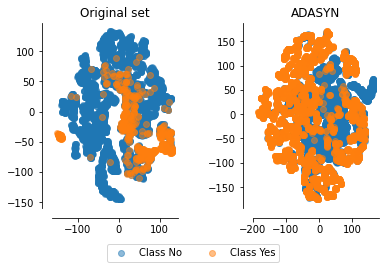

In [ ]:
tsne = TSNE(n_components=2, perplexity=11, n_iter=3000)

X_vis = tsne.fit_transform(X)
X_res_vis = tsne.fit_transform(X_resampled)

# http://glemaitre.github.io/imbalanced-learn/auto_examples/over-sampling/plot_adasyn.html

f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y == "No", 0], X_vis[y == "No", 1], label="Class No",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y == "Yes", 0], X_vis[y == "Yes", 1], label="Class Yes",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_resampled == "No", 0], X_res_vis[y_resampled == "No", 1],
            label="Class No", alpha=.5)
ax2.scatter(X_res_vis[y_resampled == "Yes", 0], X_res_vis[y_resampled == "Yes", 1],
            label="Class Yes", alpha=.5)
ax2.set_title('ADASYN')

for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

plt.figlegend((c0, c1), ('Class No', 'Class Yes'), loc='lower center',
              ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

# Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

In [ ]:
class ModelStack:
  def __init__(self, max_depth = [2, 3, 5, 10, 20], 
               min_samples_leaf = [5, 10, 20, 50, 100], 
               criterion = ["gini","entropy"], 
               C= [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
               penalty=['l2', 'l1']):
    
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.criterion = criterion
    self.C = C
    self.penalty = penalty
    self.model_series = []
    self.log = None

  def __bagging(self, X, y):
    clf = DecisionTreeClassifier(random_state=42)
    params = {
      'max_depth': self.max_depth,
      'min_samples_leaf': self.min_samples_leaf,
      'criterion': self.criterion
    }
  
    gs = GridSearchCV(clf, param_grid=params, cv=3, scoring='accuracy')
    return gs.fit(X, y)

  def __boosting(self, X, y):
    clf = LogisticRegression(random_state=42,solver='liblinear', max_iter=200)   
    params ={
    "C": self.C,
    "penalty": self.penalty
    }  
    gs = GridSearchCV(clf, param_grid=params, cv=3, scoring='accuracy')
    return gs.fit(X, y)

  def fit(self, X_train, y_train):
    d1_X_train, d2_X_train, d1_y_train, d2_y_train = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)

    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=42)
    model_series = []
    new_df = pd.DataFrame()
    idx = 0
    for train_index, test_index in rskf.split(d1_X_train, d1_y_train):
      clf = self.__bagging(d1_X_train.iloc[train_index,:], d1_y_train.iloc[train_index])
      model_series.append(clf)
      pred = clf.predict(d2_X_train)
      pred = np.where(pred == "No", 0, 1)
      new_df["model_k_"+str(idx)] = pred
      idx+=1

    self.model_series = model_series
    
    with open("bagging_model", "wb") as f:
      pickle.dump(self.model_series, f)
    
    new_df.index = d2_X_train.index
    self.log = self.__boosting(new_df, d2_y_train)

    with open("stacking_model", "wb") as f:
      pickle.dump(self.log, f)
  
  def predict(self, X_test):
    test_df = pd.DataFrame()
    for idx, clf in enumerate(self.model_series):
      pred = clf.predict(X_test)
      pred = np.where(pred == "No", 0, 1)
      test_df["model_k_"+str(idx)] = pred
    
    test_df.index = X_test.index
    return self.log.predict(test_df)

In [ ]:
ob = ModelStack()
ob.fit(X_train, y_train)

In [ ]:
print("Train Accuracy : ", accuracy_score(y_train, ob.predict(X_train)))
print("Train f1 Score : ", f1_score(np.where(y_train == "No", 0, 1), np.where(ob.predict(X_train) == "No", 0, 1)))
print("\n")
print("Test Accuracy : ", accuracy_score(y_test, ob.predict(X_test)))
print("Test f1 Score : ", f1_score(np.where(y_test == "No", 0, 1), np.where(ob.predict(X_test) == "No", 0, 1)))

Train Accuracy :  0.8989667049368542
Train f1 Score :  0.9021980735984194


Test Accuracy :  0.8826530612244898
Test f1 Score :  0.8861386138613861


In [ ]:
print("Accuracy on original X and Y: ", accuracy_score(y, ob.predict(X)))
print("f1 Score on original X and Y: ", f1_score(np.where(y == "No", 0, 1), np.where(ob.predict(X) == "No", 0, 1)))
print("Confusion matrix : \n", confusion_matrix(np.where(y == "No", 0, 1), np.where(ob.predict(X) == "No", 0, 1)))

Accuracy on original X and Y:  0.8658040665434381
f1 Score on original X and Y:  0.5562347188264058
Confusion matrix : 
 [[4229  675]
 [  51  455]]


<h1>Observation after sampling: </h1>

1. Our ensemble model is neither overfitting and underfitting. We can see by the score that our model generalized.

2. We got a much better scores compared to our baseline model which was only 0.58 for f1 and 0.95 for accuracy.

3. On our original dataset without sampling we are still facing issue with f1score, but we can see that our model is now able to classify minority class.